# **La Liga 2023/24 Match Analysis**

## **Overview**
This notebook focuses on analyzing match data from the La Liga 2023/24 season to uncover insights into team performance, match outcomes, and season trends. By processing and enriching the dataset, we aim to provide valuable insights for fans, analysts, and stakeholders in European football.

---

## **Data Source**
The dataset includes detailed information about all matches played during the La Liga 2023/24 season. Key fields include:
- **Matchday**: The round of the league.
- **Match ID**: A unique identifier for each match.
- **Teams**: Home and Away teams.
- **Scores**: Final scorelines for each match.
- **UTC Time**: The date and time of the match in Coordinated Universal Time.

---

## **Key Objectives**
1. **Data Cleaning & Transformation**:
   - Process raw data to extract meaningful insights.
   - Split aggregate scores into home and away goals.
   - Add relevant columns such as total goals, goal differences, and match outcomes.

2. **Feature Engineering**:
   - Calculate cumulative goals and points for each team.
   - Categorize matches as "Top Clashes", "Relegation Battles", or "Regular Matches".
   - Extract temporal features (day of the week, month).

3. **Statistical Analysis**:
   - Analyze match outcomes (Home Wins, Away Wins, Draws).
   - Identify high-scoring matches and trends by matchday.

4. **Visualization**:
   - Plot distributions of match outcomes and goals.
   - Highlight key matches based on their importance.

---

## **Key Features Added**
- **Home and Away Scores**: Goals scored by each team in a match.
- **Total Goals**: Sum of goals scored in a match.
- **Goal Difference**: Difference between home and away goals.
- **Match Outcome**: Categorized as Home Win, Away Win, or Draw.
- **Cumulative Goals**: Running total of goals scored by teams throughout the season.
- **Matchday Average**: Average number of goals scored per matchday.
- **Above Matchday Average**: Indicator of matches exceeding the matchday average.
- **Match Importance**: Categorization of matches based on team quality and stakes.
- **Temporal Features**: Day of the week and month of the match.

---

## **Getting Started**
This notebook begins with importing the dataset, cleaning the data, and engineering new features. It then proceeds to explore match outcomes and team performance through statistical summaries and visualizations.


In [75]:
import datetime as dt  # For working with dates and times
from math import radians, sin, cos, sqrt, atan2
import os  # For file and directory handling
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For advanced visualization
from sklearn.preprocessing import StandardScaler  # For scaling data
from sklearn.decomposition import PCA  # For Principal Component Analysis
from sklearn.cluster import KMeans  # For clustering
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA forecasting
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # For time series smoothing
from pmdarima import auto_arima  # For auto ARIMA model selection (optional)





In [76]:
# File paths for the datasets
matches_file_path = "FIFA_datasets/laliga2023_34/Laliga_matches_23_24.csv"
stadiums_file_path = "la_liga_stadiums.csv"

# Read and process the matches dataset
matches_df = (
    pd.read_csv(matches_file_path)
    .drop(columns=['Finished', 'Started', 'Cancelled', 'Awarded', 'Match Status', 'Unnamed: 12', 'Round Name'], errors='ignore')  # Drop unnecessary columns
    .assign(
        # Split the Score column into Home Score and Away Score
        Home_Score=lambda df: df['Score'].str.split('_', expand=True)[0].astype(int),
        Away_Score=lambda df: df['Score'].str.split('_', expand=True)[1].astype(int),
        # Add Total Goals, Home Goal Difference, and Away Goal Difference
        Total_Goals=lambda df: df['Home_Score'] + df['Away_Score'],
        Home_Goal_Difference=lambda df: df['Home_Score'] - df['Away_Score'],
        Away_Goal_Difference=lambda df: df['Away_Score'] - df['Home_Score'],
        # Determine Match Outcome
        Match_Outcome=lambda df: df.apply(
            lambda row: 'Home Win' if row['Home_Goal_Difference'] > 0 else (
                'Away Win' if row['Away_Goal_Difference'] > 0 else 'Draw'
            ), axis=1
        )
    )
    .drop(columns=['Score'])  # Drop the Score column after processing
    .rename(columns={'Round': 'Matchday'})  # Rename Round to Matchday
)

# Convert the 'UTC Time' column to a datetime object and set as index
matches_df['UTC Time'] = pd.to_datetime(matches_df['UTC Time'])
matches_df.set_index('UTC Time', inplace=True)

# Read the enhanced stadiums dataset
stadiums_df = pd.read_csv(stadiums_file_path)

# Function to calculate haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Merge stadium information for home teams
matches_df = matches_df.merge(
    stadiums_df, how='left', left_on='Home Team', right_on='Team'
).rename(columns={
    'Stadium Name': 'Home Stadium',
    'City': 'Home City',
    'Capacity': 'Home Stadium Capacity',
    'Latitude': 'Home Stadium Latitude',
    'Longitude': 'Home Stadium Longitude'
}).drop(columns=['Team'])  # Drop the duplicate Team column

# Merge stadium information for away teams
matches_df = matches_df.merge(
    stadiums_df, how='left', left_on='Away Team', right_on='Team'
).rename(columns={
    'Stadium Name': 'Away Stadium',
    'City': 'Away City',
    'Capacity': 'Away Stadium Capacity',
    'Latitude': 'Away Stadium Latitude',
    'Longitude': 'Away Stadium Longitude'
}).drop(columns=['Team'])  # Drop the duplicate Team column

# Calculate distance traveled for the away team
matches_df['Away Distance Traveled (km)'] = matches_df.apply(
    lambda row: haversine(
        row['Home Stadium Latitude'], row['Home Stadium Longitude'],
        row['Away Stadium Latitude'], row['Away Stadium Longitude']
    ) if not pd.isnull(row['Away Stadium Latitude']) and not pd.isnull(row['Home Stadium Latitude']) else None,
    axis=1
)

# Fill missing distances with 0 (if any)
matches_df['Away Distance Traveled (km)'] = matches_df['Away Distance Traveled (km)'].fillna(0)



In [77]:
team_performance

,Wins,Losses,Draws,Goals_Scored,Goals_Conceded,Home_Matches,Away_Matches,Home_Wins,Away_Wins,Goal_Difference,Total_Points,Home_Win_Percentage,Away_Win_Percentage
Team,,,,,,,,,,,,,
Real Madrid,29,1,8,87,26,19,19,16,13,61,95,84.210526,68.421053
Barcelona,26,5,7,79,44,19,19,15,11,35,85,78.947368,57.894737
Girona,25,7,6,85,46,19,19,15,10,39,81,78.947368,52.631579
Atletico Madrid,24,10,4,70,43,19,19,16,8,27,76,84.210526,42.105263
Athletic Club,19,8,11,61,37,19,19,12,7,24,68,63.157895,36.842105
Real Sociedad,16,10,12,51,39,19,19,8,8,12,60,42.105263,42.105263
Real Betis,14,9,15,48,45,19,19,9,5,3,57,47.368421,26.315789
Villarreal,14,13,11,65,65,19,19,7,7,0,53,36.842105,36.842105
Valencia,13,15,10,40,45,19,19,8,5,-5,49,42.105263,26.315789


---

### Match Outcome Percentages

Based on the analysis of the La Liga 2023/24 season matches, the outcomes are distributed as follows:

- **Home Wins**: 43.95% of matches were won by the home team.
- **Away Wins**: 27.89% of matches were won by the away team.
- **Draws**: 28.16% of matches ended in a draw.

This highlights the advantage of playing at home, as home teams secured nearly 44% of the victories.


---

# Advanced Analysis and Insights for La Liga 2023/24

---

## 1. **Team Performance Analysis**
### **Home vs Away Performance:**
- Calculate and compare average goals scored and conceded at home vs. away.
- Evaluate win percentages for home and away matches.

### **Dominance Metrics:**
- Identify the most dominant teams based on goal difference, points, or win streaks.

### **Top Performing Teams:**
- Rank teams by their total points, goals scored, and goals conceded.

---



In [ ]:
# Home vs Away Performance
home_performance = matches_df.groupby('Home Team').agg(
    Home_Goals_Scored=('Home_Score', 'sum'),
    Home_Goals_Conceded=('Away_Score', 'sum'),
    Home_Wins=('Match_Outcome', lambda x: (x == 'Home Win').sum()),
    Home_Draws=('Match_Outcome', lambda x: (x == 'Draw').sum()),
    Home_Losses=('Match_Outcome', lambda x: (x == 'Away Win').sum()),
    Home_Matches=('Match_Outcome', 'count')
)
home_performance['Home_Win_Percentage'] = (home_performance['Home_Wins'] / home_performance['Home_Matches']) * 100

away_performance = matches_df.groupby('Away Team').agg(
    Away_Goals_Scored=('Away_Score', 'sum'),
    Away_Goals_Conceded=('Home_Score', 'sum'),
    Away_Wins=('Match_Outcome', lambda x: (x == 'Away Win').sum()),
    Away_Draws=('Match_Outcome', lambda x: (x == 'Draw').sum()),
    Away_Losses=('Match_Outcome', lambda x: (x == 'Home Win').sum()),
    Away_Matches=('Match_Outcome', 'count')
)
away_performance['Away_Win_Percentage'] = (away_performance['Away_Wins'] / away_performance['Away_Matches']) * 100

# Merge Home and Away Performance
team_performance = home_performance.merge(
    away_performance,
    left_index=True,
    right_index=True,
    suffixes=('_Home', '_Away')
)

# Dominance Metrics
team_performance['Total_Goals_Scored'] = team_performance['Home_Goals_Scored'] + team_performance['Away_Goals_Scored']
team_performance['Total_Goals_Conceded'] = team_performance['Home_Goals_Conceded'] + team_performance['Away_Goals_Conceded']
team_performance['Goal_Difference'] = team_performance['Total_Goals_Scored'] - team_performance['Total_Goals_Conceded']
team_performance['Total_Wins'] = team_performance['Home_Wins'] + team_performance['Away_Wins']
team_performance['Total_Draws'] = team_performance['Home_Draws'] + team_performance['Away_Draws']
team_performance['Total_Losses'] = team_performance['Home_Losses'] + team_performance['Away_Losses']
team_performance['Total_Matches'] = team_performance['Home_Matches'] + team_performance['Away_Matches']
team_performance['Total_Points'] = (team_performance['Total_Wins'] * 3) + team_performance['Total_Draws']

# Top Performing Teams
top_teams = team_performance.sort_values(by='Total_Points', ascending=False)

# Display insights
print("\n--- Team Performance Analysis ---")
print("\nHome vs Away Performance:")
print(team_performance[['Home_Win_Percentage', 'Away_Win_Percentage']].sort_values(by='Home_Win_Percentage', ascending=False).head(10))

print("\nTop Performing Teams by Total Points:")
print(top_teams[['Total_Points', 'Total_Wins', 'Goal_Difference']].head(10))

plt.figure(figsize=(12, 6))
top_teams['Total_Points'].head(10).plot(kind='bar', color='blue', alpha=0.7)
plt.title("Top 10 Teams by Total Points", fontsize=14)
plt.xlabel("Teams", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [78]:
matches_df

,Matchday,Match ID,Home Team,Away Team,Home_Score,Away_Score,Total_Goals,Home_Goal_Difference,Away_Goal_Difference,Match_Outcome,...,Home City,Home Stadium Latitude,Home Stadium Longitude,Home Stadium Capacity,Away Stadium,Away City,Away Stadium Latitude,Away Stadium Longitude,Away Stadium Capacity,Away Distance Traveled (km)
0,1,4205343,Almeria,Rayo Vallecano,0,2,2,-2,2,Away Win,...,Almeria,36.8496,-2.4381,15000,Campo de Futbol de Vallecas,Madrid,40.3918,-3.6588,14708,407.888662
1,1,4205347,Sevilla,Valencia,1,2,3,-1,1,Away Win,...,Seville,37.3841,-5.9703,43883,Mestalla,Valencia,39.4746,-0.3585,49000,541.144868
2,1,4205351,Real Sociedad,Girona,1,1,2,0,0,Draw,...,San Sebastian,43.3018,-1.9731,39500,Estadi Montilivi,Girona,41.9630,2.8374,13500,420.672549
3,1,4205348,Las Palmas,Mallorca,1,1,2,0,0,Draw,...,Las Palmas,28.1248,-15.4300,32500,Visit Mallorca Estadi,Palma,39.5893,2.6502,23142,2093.619297
4,1,4205344,Athletic Club,Real Madrid,0,2,2,-2,2,Away Win,...,Bilbao,43.2641,-2.9494,53289,Santiago Bernabeu,Madrid,40.4531,-3.6884,81044,318.500299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,38,4205721,Real Madrid,Real Betis,0,0,0,0,0,Draw,...,Madrid,40.4531,-3.6884,81044,Estadio Benito Villamarin,Seville,37.3565,-5.9812,60721,397.356125
376,38,4205715,Getafe,Mallorca,1,2,3,-1,1,Away Win,...,Getafe,40.3250,-3.7146,17393,Visit Mallorca Estadi,Palma,39.5893,2.6502,23142,548.503425
377,38,4205714,Celta Vigo,Valencia,2,2,4,0,0,Draw,...,Vigo,42.2118,-8.7392,29000,Mestalla,Valencia,39.4746,-0.3585,49000,767.427238
378,38,4205722,Las Palmas,Deportivo Alaves,1,1,2,0,0,Draw,...,Las Palmas,28.1248,-15.4300,32500,Mendizorrotza,Vitoria-Gasteiz,42.8498,-2.6813,19840,1998.193054


## 2. **Match Insights**
### **High-Scoring Matches:**
- Identify the matches with the highest total goals.
- Analyze if high-scoring matches are more common at specific stadiums or involving certain teams.

### **Distance Impact:**
- Investigate if greater travel distances for away teams correlate with poorer performance (e.g., fewer goals scored or lower win percentage).

### **Stadium Influence:**
- Compare the performance of teams at large vs. small-capacity stadiums.
- Determine if certain stadiums are harder to win at ("fortresses").

---




/var/folders/gg/vmh0mv_j5b90pkytkpd35k940000gn/T/ipykernel_12603/1038511151.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


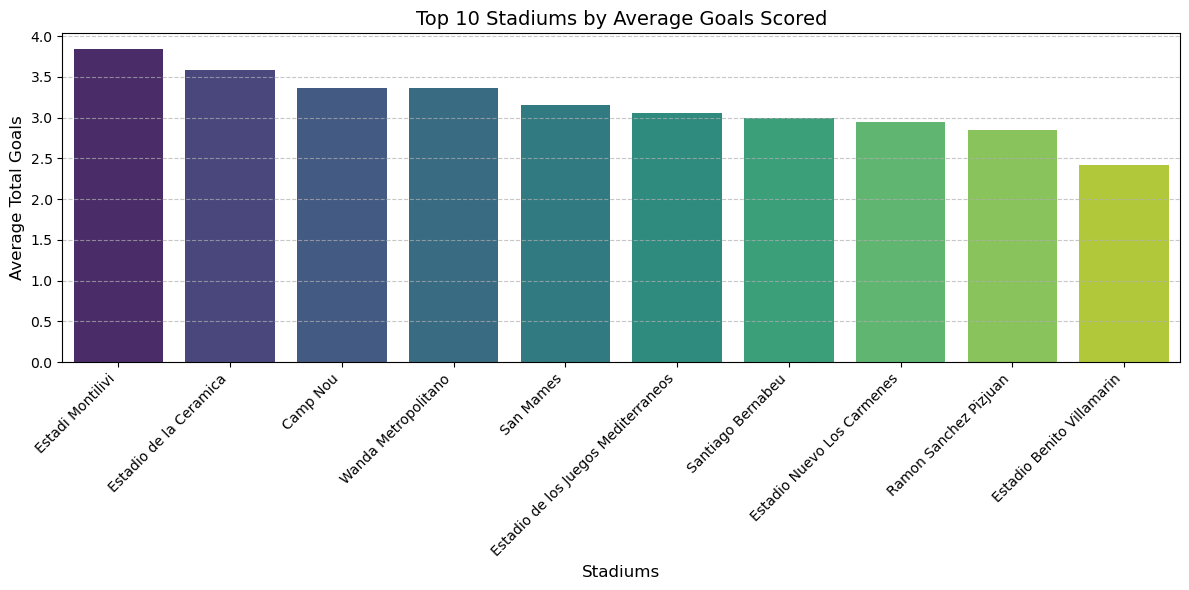

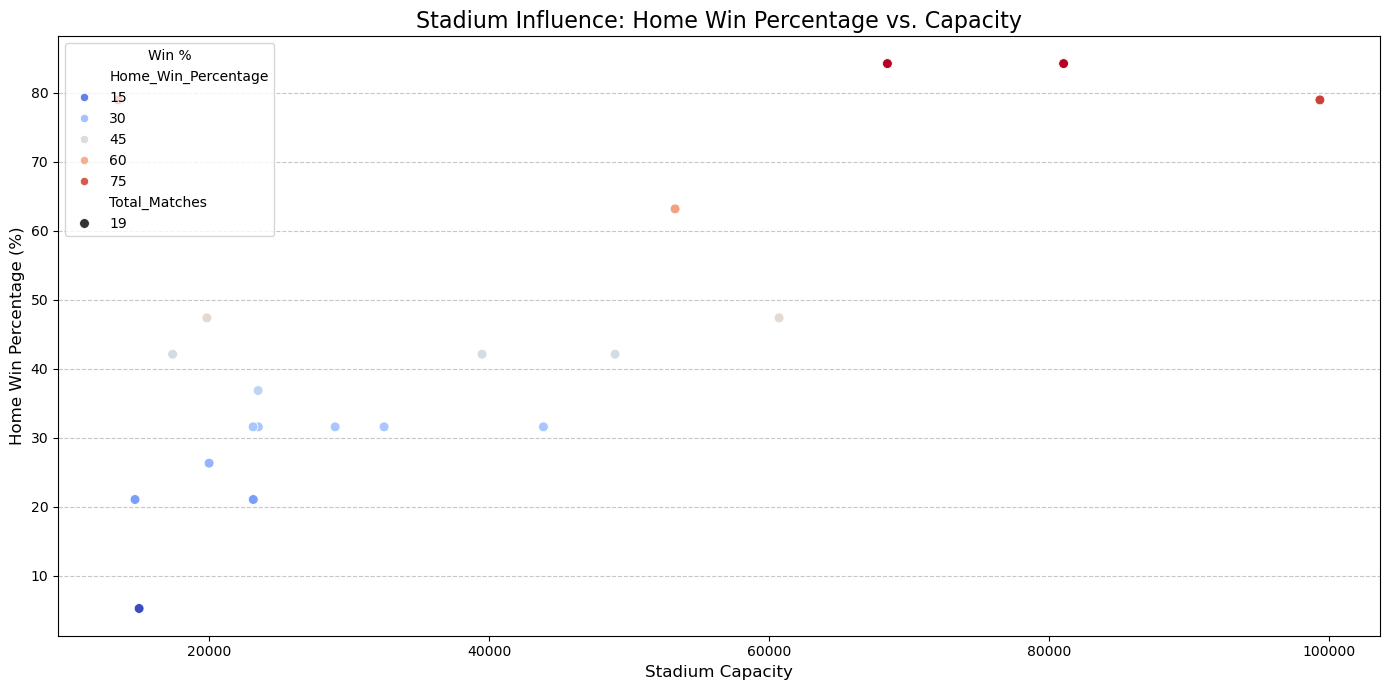

In [81]:
# High-Scoring Matches
high_scoring_matches = matches_df.sort_values(by='Total_Goals', ascending=False).head(10)


# Analyze high-scoring matches by stadium
high_scoring_stadiums = matches_df.groupby('Home Stadium')['Total_Goals'].mean().sort_values(ascending=False)


# Visualization: High-Scoring Stadiums
plt.figure(figsize=(12, 6))
sns.barplot(
    x=high_scoring_stadiums.head(10).index,
    y=high_scoring_stadiums.head(10).values,
    palette="viridis"
)
plt.title("Top 10 Stadiums by Average Goals Scored", fontsize=14)
plt.xlabel("Stadiums", fontsize=12)
plt.ylabel("Average Total Goals", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate and align x-tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Visualization: Stadium Influence
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x='Stadium_Capacity',
    y='Home_Win_Percentage',
    size='Total_Matches',
    sizes=(50, 300),
    hue='Home_Win_Percentage',
    palette="coolwarm",
    data=stadium_influence.reset_index()
)
plt.title("Stadium Influence: Home Win Percentage vs. Capacity", fontsize=16)
plt.xlabel("Stadium Capacity", fontsize=12)
plt.ylabel("Home Win Percentage (%)", fontsize=12)
plt.legend(title="Win %", loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



## 3. **Seasonal Trends**
### **Goal Trends Over Matchdays:**
- Analyze trends in total goals scored across matchdays.
- Determine if certain parts of the season (e.g., beginning, middle, or end) have more high-scoring matches.

### **Travel Trends:**
- Evaluate which teams traveled the most and the least during the season.
- Correlate travel distances with match outcomes and fatigue effects.

---



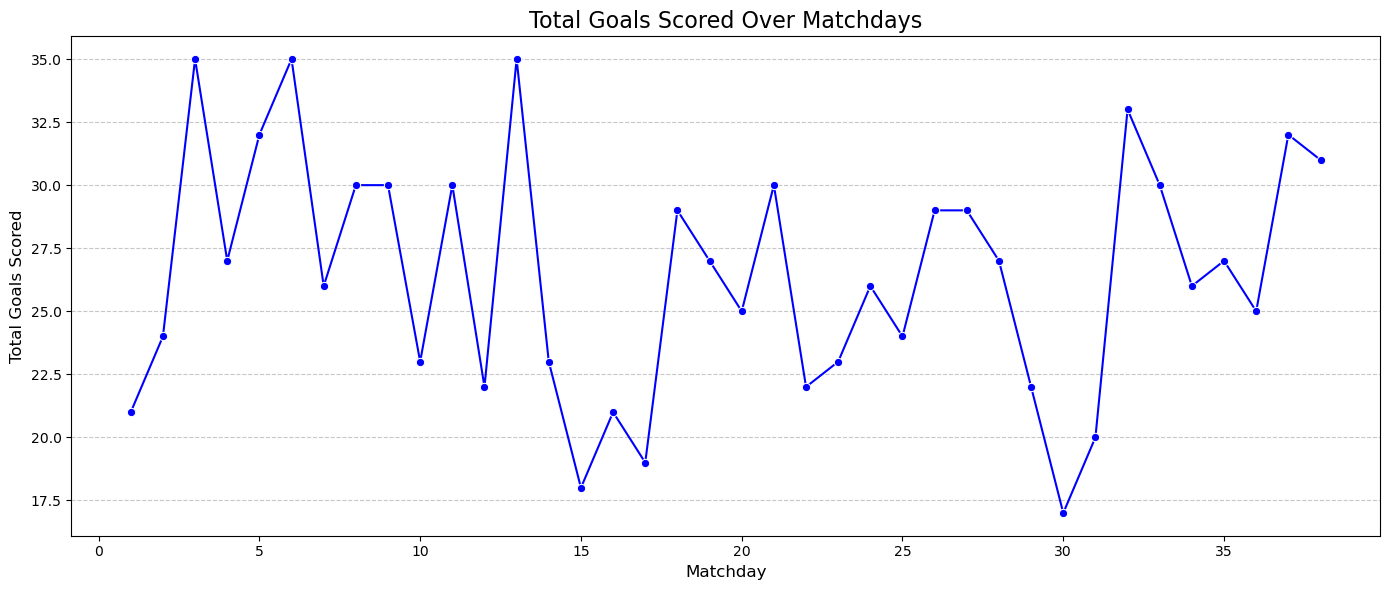


--- Teams with the Most Travel ---
Away Team
Las Palmas    34113.707267
Celta Vigo    13450.024266
Girona        12632.812974
Mallorca      12085.542969
Cadiz         11919.325342
Name: Away Distance Traveled (km), dtype: float64

--- Teams with the Least Travel ---
Away Team
Valencia           8995.211505
Getafe             7791.431679
Real Madrid        7790.232801
Rayo Vallecano     7767.238693
Atletico Madrid    7763.479455
Name: Away Distance Traveled (km), dtype: float64


/var/folders/gg/vmh0mv_j5b90pkytkpd35k940000gn/T/ipykernel_12603/1645680978.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


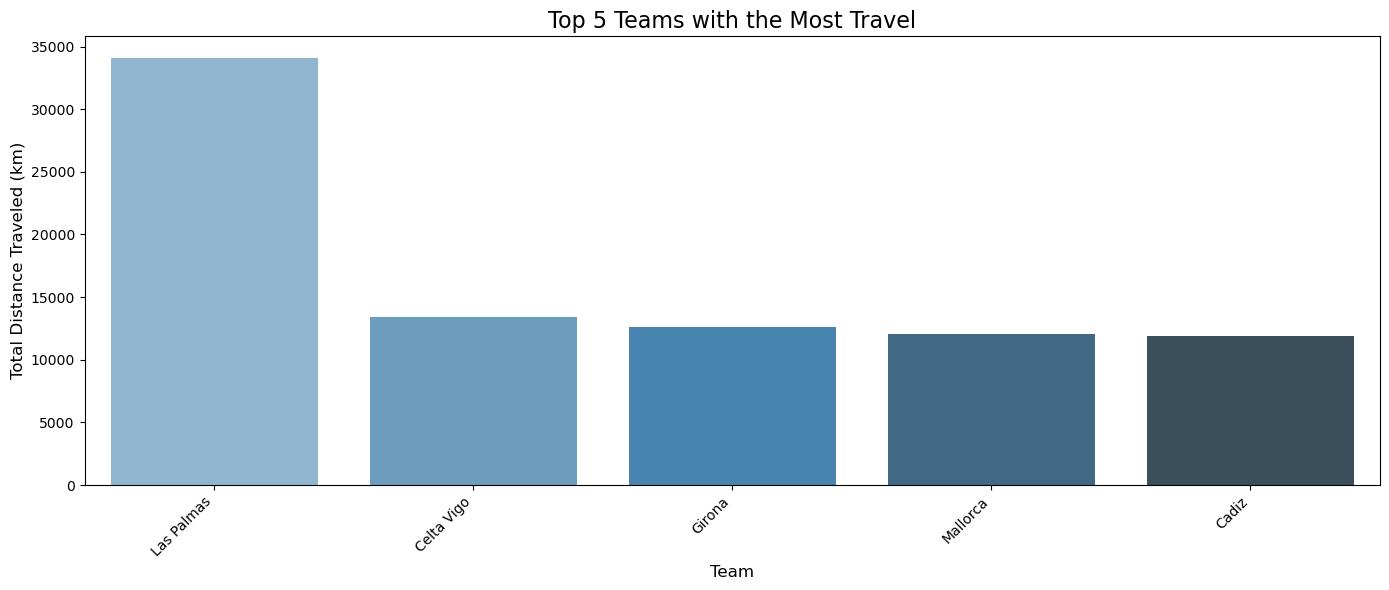

/var/folders/gg/vmh0mv_j5b90pkytkpd35k940000gn/T/ipykernel_12603/1645680978.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


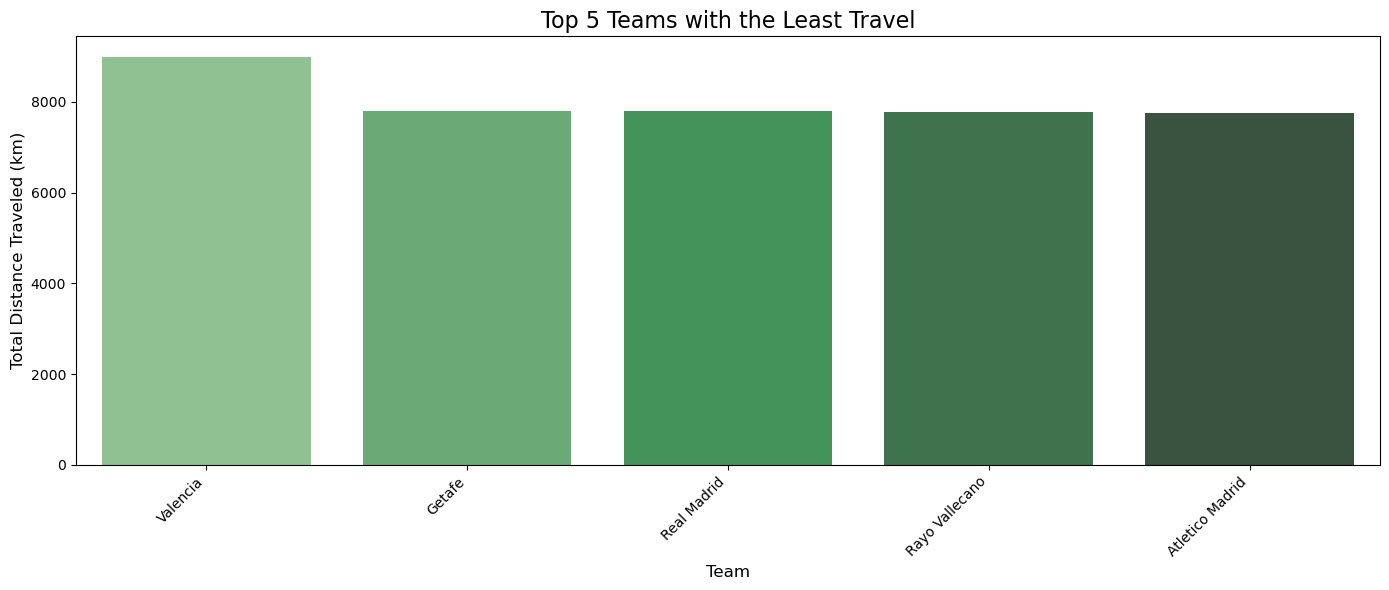

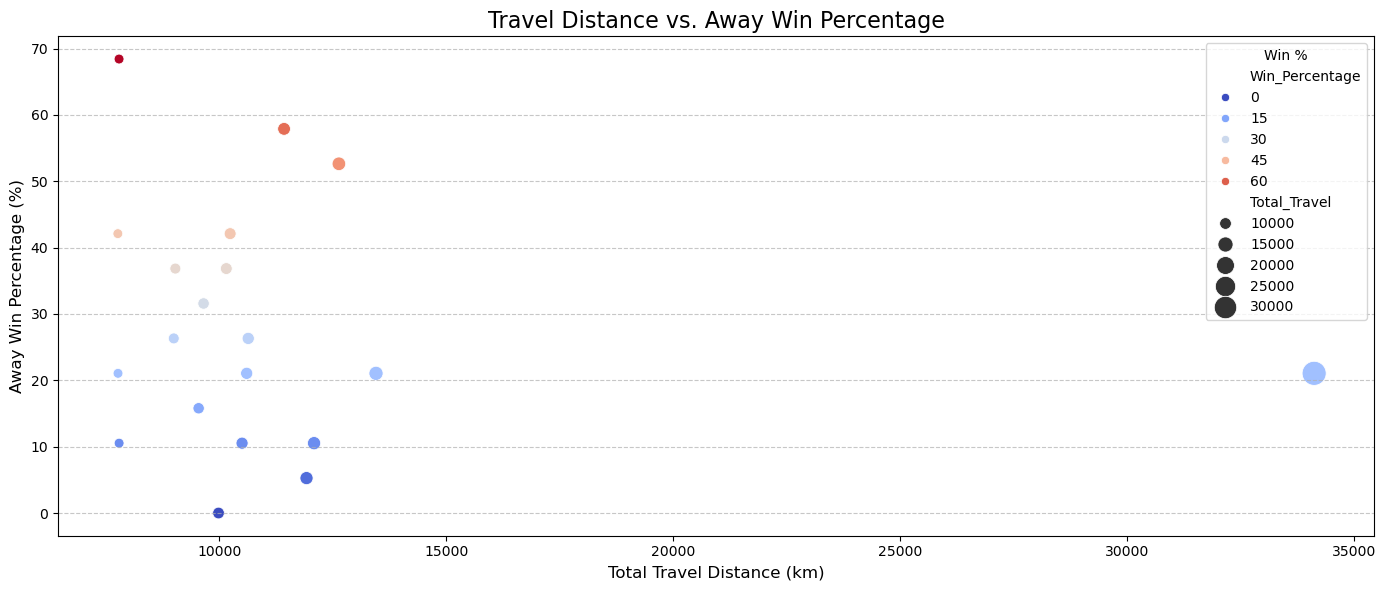

In [83]:
# Analyze Total Goals Scored Across Matchdays
matchday_goals = matches_df.groupby('Matchday')['Total_Goals'].sum()

# Visualization: Goal Trends Over Matchdays
plt.figure(figsize=(14, 6))
sns.lineplot(data=matchday_goals, marker='o', color='blue')
plt.title("Total Goals Scored Over Matchdays", fontsize=16)
plt.xlabel("Matchday", fontsize=12)
plt.ylabel("Total Goals Scored", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Determine Travel Trends
travel_trends = matches_df.groupby('Away Team')['Away Distance Traveled (km)'].sum().sort_values(ascending=False)

# Teams that traveled the most and least during the season
most_travel = travel_trends.head(5)
least_travel = travel_trends.tail(5)

print("\n--- Teams with the Most Travel ---")
print(most_travel)

print("\n--- Teams with the Least Travel ---")
print(least_travel)

# Visualization: Travel Trends
plt.figure(figsize=(14, 6))
sns.barplot(
    x=most_travel.index,
    y=most_travel.values,
    palette="Blues_d"
)
plt.title("Top 5 Teams with the Most Travel", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Distance Traveled (km)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(
    x=least_travel.index,
    y=least_travel.values,
    palette="Greens_d"
)
plt.title("Top 5 Teams with the Least Travel", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Total Distance Traveled (km)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlation Between Travel Distance and Match Outcomes
travel_impact = matches_df.groupby('Away Team').agg(
    Total_Travel=('Away Distance Traveled (km)', 'sum'),
    Away_Wins=('Match_Outcome', lambda x: (x == 'Away Win').sum()),
    Away_Draws=('Match_Outcome', lambda x: (x == 'Draw').sum()),
    Away_Losses=('Match_Outcome', lambda x: ((x != 'Away Win') & (x != 'Draw')).sum())
)
travel_impact['Win_Percentage'] = (travel_impact['Away_Wins'] / 
                                   (travel_impact['Away_Wins'] + travel_impact['Away_Draws'] + travel_impact['Away_Losses'])) * 100

# Visualization: Travel Distance vs. Win Percentage
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='Total_Travel',
    y='Win_Percentage',
    size='Total_Travel',
    sizes=(50, 300),
    hue='Win_Percentage',
    palette="coolwarm",
    data=travel_impact
)
plt.title("Travel Distance vs. Away Win Percentage", fontsize=16)
plt.xlabel("Total Travel Distance (km)", fontsize=12)
plt.ylabel("Away Win Percentage (%)", fontsize=12)
plt.legend(title="Win %", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 4. **Geographic Insights**
### **Regional Rivalries:**
- Highlight matches between geographically close teams ("derbies").
- Analyze their intensity based on goals, cards, or outcomes.

### **Travel Hotspots:**
- Identify teams or stadiums that require the most travel for away teams.

---



## 5. **Player and Team Behavior**
### **Comeback Kings:**
- Identify teams that frequently win or draw after trailing.

### **Defensive Solidity:**
- Highlight teams that rarely concede goals, especially at home.

---





## 6. **Attendance and Revenue Potential**
*(If attendance data is available or estimations can be derived based on stadium capacity):*
- Analyze average attendance for home matches.
- Estimate potential revenue from ticket sales using average attendance and ticket prices.

---

## 7. **Clustering and Segmentation**
- Use clustering algorithms to group teams based on:
  - Scoring patterns (e.g., high-scoring vs. defensively solid teams).
  - Travel and performance patterns (e.g., teams that struggle in away matches).

---

## 8. **Predictive Modeling**
### **Match Outcome Prediction:**
- Use features like distance traveled, team form, and goals scored/conceded to predict match outcomes.

### **Relegation Risk:**
- Analyze which teams are at risk of relegation based on their points and remaining fixtures.

---



## 9. **Interactive Visualizations**
- Create visualizations to explore:
  - Heatmaps of travel distances between stadiums.
  - Scatter plots of goals scored vs. goals conceded.
  - Maps showing the locations of stadiums and travel routes.

---



## 10. **Rivalry and Competition Intensity**
- Identify intense rivalries based on:
  - Goal differences across matches.
  - Historical win-loss records between teams.

---